<a href="https://colab.research.google.com/github/claredavies/DataEngAPITesting/blob/master/AnamolyDetection/HTTP_Response/Supervised/Monitor_Latency_StatusCode_Supervised_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [1]:
import pandas as pd
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
!pip install pyod

from pandas import read_csv
from pandas.plotting import scatter_matrix
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from pyod.models.mad import MAD
from pyod.models.knn import KNN
from pyod.models.lof import LOF

     |████████████████████████████████| 118 kB 5.2 MB/s 
  Created wheel for pyod: filename=pyod-1.0.0-py3-none-any.whl size=144471 sha256=f495106514747c97f254e0bbe17efc3c6164a6c946377f5577834012339407aa
  Stored in directory: /root/.cache/pip/wheels/37/e6/25/8098880dadf78bf063ee9b37477b1a9317e8bb0fc06e623187
Successfully built pyod


# Read in data

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
print(train.head())

       Time Method  Code  Delay  Y
0  11:00:00    GET   200  15000  1
1  11:00:01   POST   201  15000  1
2  11:00:02   POST   201  16000  1
3  11:00:03    GET   200  16000  1
4  11:00:04    GET   200  18000  1


In [4]:
print(train['Code'].unique())

[200 201 404 302 204 400 500]


# Data Processing

In [5]:
train['Code'].value_counts()

200    22514
201     1497
400      590
404      484
204      278
302       46
500       43
Name: Code, dtype: int64

In [6]:
one_hot_encoded_train = pd.get_dummies(train, columns = ['Code'])
print(one_hot_encoded_train)

           Time Method  Delay  Y  Code_200  Code_201  Code_204  Code_302  \
0      11:00:00    GET  15000  1         1         0         0         0   
1      11:00:01   POST  15000  1         0         1         0         0   
2      11:00:02   POST  16000  1         0         1         0         0   
3      11:00:03    GET  16000  1         1         0         0         0   
4      11:00:04    GET  18000  1         1         0         0         0   
...         ...    ...    ... ..       ...       ...       ...       ...   
25447  18:03:23    GET  15000  1         1         0         0         0   
25448  18:03:24    GET  16000  1         1         0         0         0   
25449  18:03:25    GET  15000  1         1         0         0         0   
25450  18:03:26    GET  16000  1         1         0         0         0   
25451  18:03:27    GET  15000  1         1         0         0         0   

       Code_400  Code_404  Code_500  
0             0         0         0  
1          

In [7]:
train = one_hot_encoded_train[["Delay", "Code_200", "Code_201", "Code_204", "Code_302", "Code_400", "Code_404", "Code_500","Y"]]

In [8]:
print(train.head)

<bound method NDFrame.head of        Delay  Code_200  Code_201  Code_204  Code_302  Code_400  Code_404  \
0      15000         1         0         0         0         0         0   
1      15000         0         1         0         0         0         0   
2      16000         0         1         0         0         0         0   
3      16000         1         0         0         0         0         0   
4      18000         1         0         0         0         0         0   
...      ...       ...       ...       ...       ...       ...       ...   
25447  15000         1         0         0         0         0         0   
25448  16000         1         0         0         0         0         0   
25449  15000         1         0         0         0         0         0   
25450  16000         1         0         0         0         0         0   
25451  15000         1         0         0         0         0         0   

       Code_500  Y  
0             0  1  
1             0

In [9]:
X_train=train[["Delay", "Code_200", "Code_201", "Code_204", "Code_302", "Code_400", "Code_404", "Code_500"]]
y_train=train[["Y"]]

In [11]:
test = pd.read_csv("test.csv")
one_hot_encoded_test = pd.get_dummies(test, columns = ['Code'])

In [12]:
test = one_hot_encoded_test[["Delay", "Code_200", "Code_201", "Code_204", "Code_302", "Code_400", "Code_404", "Code_500","Y"]]

In [13]:
X_test=test[["Delay", "Code_200", "Code_201", "Code_204", "Code_302", "Code_400", "Code_404", "Code_500"]]
y_test=test[["Y"]]

In [14]:
print(y_train.head())
print(X_train.head())


   Y
0  1
1  1
2  1
3  1
4  1
   Delay  Code_200  Code_201  Code_204  Code_302  Code_400  Code_404  Code_500
0  15000         1         0         0         0         0         0         0
1  15000         0         1         0         0         0         0         0
2  16000         0         1         0         0         0         0         0
3  16000         1         0         0         0         0         0         0
4  18000         1         0         0         0         0         0         0


In [15]:
y_train.loc[y_train["Y"] == -1, "Y"] = 0
y_test.loc[y_test["Y"] == -1, "Y"] = 0

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


# Metrics

In [16]:
def get_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  return cm

def plot_cm(ax,labels, predictions,title, p=0.5):
  tick_labels = ['Y', 'N']
  cm = get_cm(labels, predictions, p)
  sns.heatmap(cm, annot=True, fmt="d",ax=ax)
  ax.title.set_text(title)
  ax.set_xticklabels(tick_labels)
  ax.set_yticklabels(tick_labels)

# Data Exploration

Anamoly Resampled 25408
Not-Anamoly Resampled 44
Subscribe Resampled proportion 99.83%


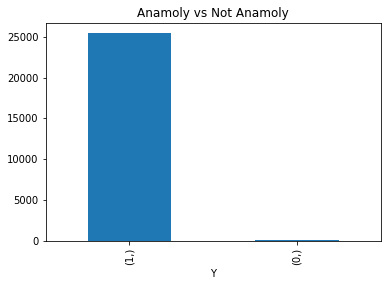

In [17]:
def percentage(part, whole):
  return 100 * float(part) / float(whole)

anamoly, not_anamoly = y_train.value_counts()
print(f'Anamoly Resampled {anamoly}')
print(f'Not-Anamoly Resampled {not_anamoly}')
print(f'Subscribe Resampled proportion {round(percentage(anamoly,anamoly + not_anamoly), 2)}%')

y_train.value_counts().plot(kind="bar", title="Anamoly vs Not Anamoly");

# Resampling

In [18]:
print(y_train['Y'].unique())
print(y_train['Y'].unique())

[1 0]
[1 0]


In [19]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=0,  k_neighbors=2)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


Anamoly Resampled 25408
Not-Anamoly Resampled 25408
Subscribe Resampled proportion 50.0%


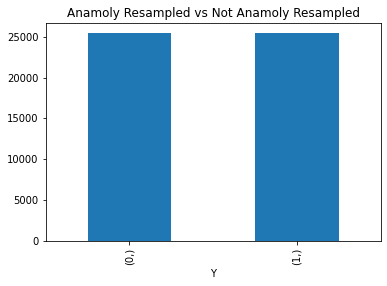

In [20]:
def percentage(part, whole):
  return 100 * float(part) / float(whole)

anamoly_resampled, not_anamoly_resampled = y_train_resampled.value_counts()
print(f'Anamoly Resampled {anamoly_resampled}')
print(f'Not-Anamoly Resampled {not_anamoly_resampled}')
print(f'Subscribe Resampled proportion {round(percentage(anamoly_resampled,anamoly_resampled + not_anamoly_resampled), 2)}%')

y_train_resampled.value_counts().plot(kind="bar", title="Anamoly Resampled vs Not Anamoly Resampled");

In [21]:
print(y_train_resampled.head(100))

    Y
0   1
1   1
2   1
3   1
4   1
.. ..
95  1
96  1
97  1
98  1
99  1

[100 rows x 1 columns]


# Weighting

In [22]:
anamoly_count, not_anamoly_count = np.bincount(y_train.Y)
total_count = len(y_train.Y)

weight_anamoly = ((1 / anamoly_count) * (total_count) / 2.0 )
weight_not_anamoly = (((1 / not_anamoly_count) * (total_count) / 2.0 )) 
print("Anamoly:  " + str(weight_anamoly))
print("Not anamoly:  " + str(weight_not_anamoly))
class_weights = {0: weight_anamoly, 1: weight_not_anamoly}

Anamoly:  289.22727272727275
Not anamoly:  0.5008658690176322


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


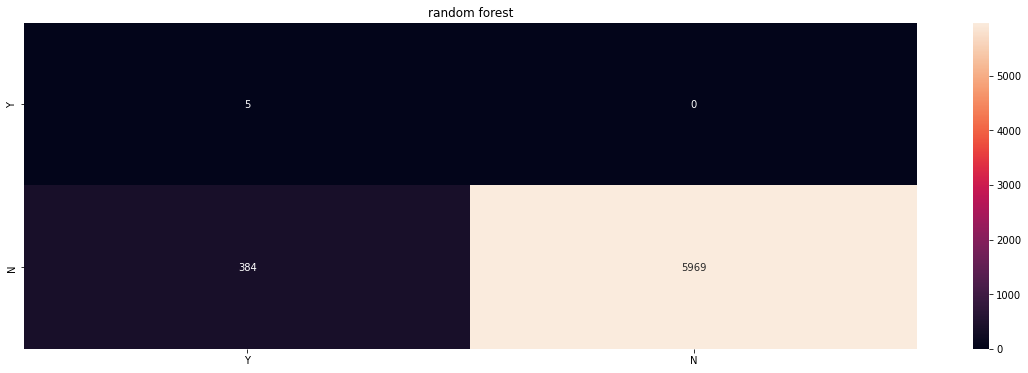

In [23]:
from imblearn.ensemble import BalancedRandomForestClassifier

clf = BalancedRandomForestClassifier(max_depth=2, random_state=0,class_weight=class_weights)
clf.fit(X_train, y_train) 
predictions = clf.predict(X_test)
fig, (ax1) = plt.subplots(1, 1,figsize=(20,6))
plot_cm(ax1,y_test, predictions,"random forest")

# ML

In [24]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

models = {}

models['LR'] = LogisticRegression()
models['LDA'] = LinearDiscriminantAnalysis()
models['KNN'] = KNeighborsClassifier()
models['CART'] = DecisionTreeClassifier()
models['NB'] = GaussianNB()
models['SVM'] = SVC(gamma='auto')

accuracy, precision, recall, predictions = {}, {}, {}, {}
for key in models.keys():
    models[key].fit(X_train_resampled, y_train_resampled['Y'])
    predictions[key] = models[key].predict(X_test)
    
    accuracy[key] = accuracy_score(predictions[key], y_test['Y'])
    precision[key] = precision_score(predictions[key], y_test['Y'])
    recall[key] = recall_score(predictions[key], y_test['Y'])

      Accuracy  Precision    Recall
LR    0.862693   0.862742  0.999818
LDA   0.999214   0.999528  0.999685
KNN   0.999685   1.000000  0.999685
CART  0.986474   0.986620  0.999840
NB    0.960208   0.960334  0.999836
SVM   0.986474   0.986620  0.999840


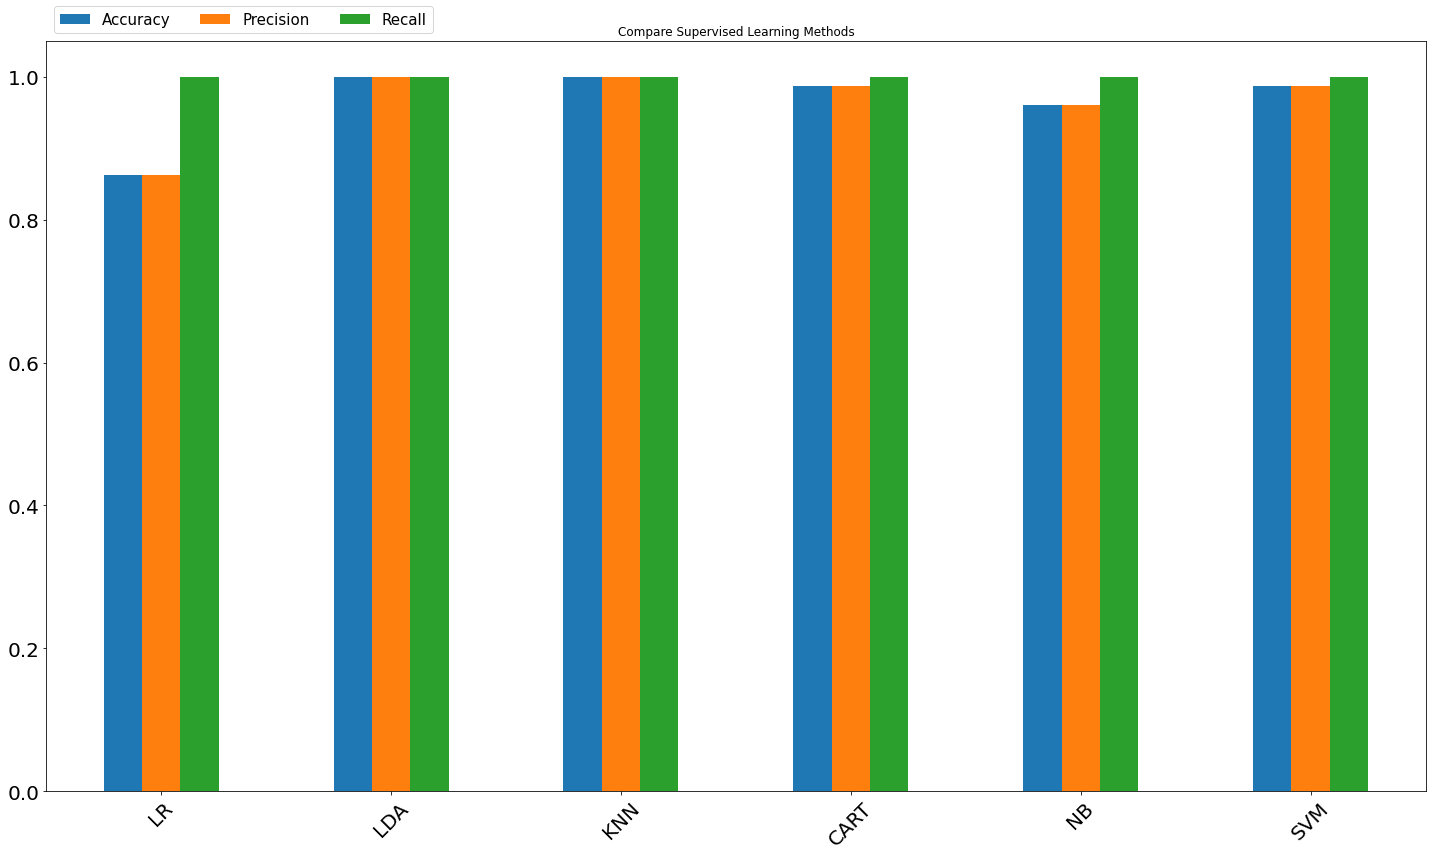

In [25]:
import pandas as pd

df_model = pd.DataFrame(index=models.keys(), columns=['Accuracy'])
df_model = pd.DataFrame(index=models.keys(), columns=['Accuracy', 'Precision', 'Recall'])
df_model['Accuracy'] = accuracy.values()
df_model['Precision'] = precision.values()
df_model['Recall'] = recall.values()

print(df_model)

plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
ax  = df_model.plot.bar(rot=45,figsize=(20,12),title="Compare Supervised Learning Methods")
ax.legend(ncol= len(models.keys()), bbox_to_anchor=(0, 1), loc='lower left', prop={'size': 15})
plt.tight_layout()

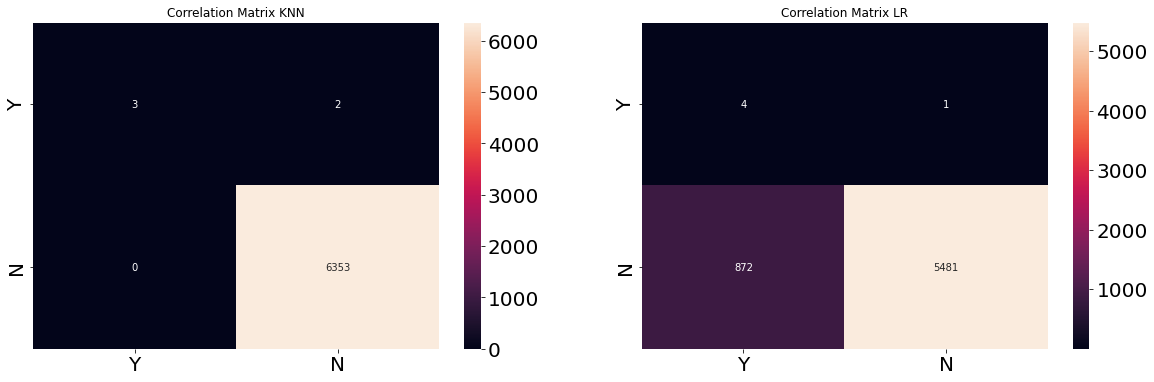

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,6))
plot_cm(ax1,y_test, predictions['KNN'],"Correlation Matrix KNN")
plot_cm(ax2,y_test, predictions['LR'],"Correlation Matrix LR")

# Metrics

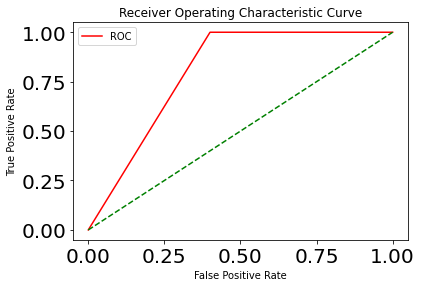

In [35]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = models["KNN"].predict_proba(X_test)
prob = probs[:, 1]
fper, tper, thresholds = metrics.roc_curve(y_test, prob)

def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()

plot_roc_curve(fper, tper)